In [21]:
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error
from bson import ObjectId
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client[os.getenv('MONGO_DB_NAME')]

users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']
answers_collection = db['answers']  # Add answers collection    


In [22]:
def predict_rating(user_idx, post_idx, train_matrix, user_similarity):
    sim_scores = user_similarity[user_idx]
    item_ratings = train_matrix[:, post_idx]
    non_zero_ratings = item_ratings[item_ratings != 0]

    weighted_sum = 0
    similarity_sum = 0
    for idx in range(len(non_zero_ratings)):
        similarity = sim_scores[idx]
        weighted_sum += similarity * item_ratings[idx]
        similarity_sum += similarity

    if similarity_sum == 0:
        return 0
    return weighted_sum / similarity_sum

query='apa'
def train_search_model(query):
    # Fetch data from MongoDB
    users = list(users_collection.find())
    search_query = {
        "$or": [
            { "date": { "$regex": query, "$options": "i" } },
            { "question": { "$regex": query, "$options": "i" } },
            { "topic": { "$regex": query, "$options": "i" } },
            { "id_user": { "$regex": query, "$options": "i" } },
            { "title": { "$regex": query, "$options": "i" } },
            { "post_pic": { "$regex": query, "$options": "i" } }
        ]
    }
    posts = list(posts_collection.find(search_query))

    if not posts:
        posts = list(posts_collection.find())
        
    # Get likes for filtered posts
    post_ids = [str(post['_id']) for post in posts]
    likes = list(likes_collection.find({'post_id': {'$in': post_ids}}))
    # Get answers for filtered posts
    answers = list(answers_collection.find({'post_id': {'$in': post_ids}}))


     # Create mappings for user and post IDs (using string IDs)
    user_ids = {str(user['_id']): idx for idx, user in enumerate(users)}
    post_ids = {str(post['_id']): idx for idx, post in enumerate(posts)}

    print('post_id: ', post_ids , 'user_ids: ', user_ids)

    # Create rating matrix
    num_users = len(users)
    num_posts = len(posts)
    ratings_matrix = np.zeros((num_users, num_posts))

    for like in likes:
        user_id_str = str(like['user_id'])
        post_id_str = str(like['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    for answer in answers:
        user_id_str = str(answer['user_id'])
        post_id_str = str(answer['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    def create_train_test_split(ratings_matrix, test_size=0.2):
        num_users, num_posts = ratings_matrix.shape
        # Create an empty matrix for train and test
        train_matrix = np.copy(ratings_matrix)
        test_matrix = np.zeros_like(ratings_matrix)

        for user in range(num_users):
            # Find the indices of non-zero entries (interactions) for the current user
            non_zero_indices = np.nonzero(ratings_matrix[user])[0]
            
            if len(non_zero_indices) < 2:
                continue  # Skip users with less than two interactions
            
            # Split indices into train and test
            train_indices, test_indices = train_test_split(non_zero_indices, test_size=test_size, random_state=42)
            
            # Update train and test matrices
            train_matrix[user, train_indices] = ratings_matrix[user, train_indices]
            test_matrix[user, test_indices] = ratings_matrix[user, test_indices]

        return train_matrix, test_matrix

    # Train-test split
    train_matrix, test_matrix = create_train_test_split(ratings_matrix, test_size=0.2)

    # Visualize the ratings matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(train_matrix, cmap='YlGnBu', cbar=True)
    plt.title('Training Ratings Matrix')
    plt.xlabel('Posts')
    plt.ylabel('Users')
    plt.show()

    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(train_matrix)
    print('------------------------------------------------------')
    print('user similarity shape: ', user_similarity.shape)
    print('user similarity: ', user_similarity)
    print('------------------------------------------------------')

    # Visualize the user similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity, cmap='coolwarm', cbar=True)
    plt.title('User Similarity Matrix')
    plt.xlabel('Users')
    plt.ylabel('Users')
    plt.show()
    
    # Function to recommend posts for a given user based on similar users' likes
    def recommend_posts(user_idx, num_recommendations=5):
        print('Processing recommendations for user index:', user_idx)
        sim_scores = user_similarity[user_idx]
        print('sim_scores: ', sim_scores)
        print('------------------------------------------------------')
        
        similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
        print('similar users: ', similar_users)
        print('------------------------------------------------------')
        
        post_scores = np.zeros(num_posts)
    
        for similar_user in similar_users:
            post_scores += sim_scores[similar_user] * train_matrix[similar_user]
            print('post score: ', post_scores)
            print('------------------------------------------------------')

        print('post score rate: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        post_scores[train_matrix[user_idx] > 0] = 0
        print('post score filter: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
        return recommended_post_indices

    # Generate recommendations for all users and save to a dictionary
    recommendations = {}
    for user_id_str, user_idx in user_ids.items():
        if user_idx >= user_similarity.shape[0]:
            print(f"User index {user_idx} is out of bounds for user_similarity with shape {user_similarity.shape}")
            continue
        recommended_posts = recommend_posts(user_idx, num_recommendations=5)
        print('------------------------------------------------------')
        print('search_recommended posts: ', recommended_posts)
        print('------------------------------------------------------')
        recommended_post_ids = [list(post_ids.keys())[list(post_ids.values()).index(post_idx)] for post_idx in recommended_posts]
        recommendations[user_id_str] = recommended_post_ids

    # Save recommendations to a JSON file
    with open('search_recommendations.json', 'w') as f:
        json.dump(recommendations, f)

    # Evaluate model
    actual_ratings = []
    predicted_ratings = []

    for user_idx in range(len(test_matrix)):
        for post_idx in range(num_posts):
            if test_matrix[user_idx, post_idx] != 0:
                actual_ratings.append(test_matrix[user_idx, post_idx])
                predicted_ratings.append(predict_rating(user_idx, post_idx, train_matrix, user_similarity))
                
                
    
    # Tambahkan pengecekan untuk memastikan kedua array tidak kosong
    if len(actual_ratings) == 0 or len(predicted_ratings) == 0:
        print("Warning: Salah satu atau kedua array kosong.")
    else:
        
        # Menetapkan ambang batas
        threshold = 0.5  
        
        # Mengubah prediksi ke dalam format biner berdasarkan ambang batas
        binary_predictions = [1 if p >= threshold else 0 for p in predicted_ratings]
        binary_actuals = [1 if a >= threshold else 0 for a in actual_ratings]
        
        # Menghitung MAE
        mae = mean_absolute_error(binary_actuals, binary_predictions)
        # Menghitung Precision, Recall, F1 Score, dan Confusion Matrix
        conf_matrix = confusion_matrix(binary_actuals, binary_predictions)
        class_report = classification_report(binary_actuals, binary_predictions, output_dict=True)
        
        # Visualisasi Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Menampilkan laporan klasifikasi
        print("Classification Report:")
        print(classification_report(binary_actuals, binary_predictions))

        # Menampilkan MAE
        print(f'Mean Absolute Error: {mae}')
        
        # Menghitung dan menampilkan Precision, Recall, dan F1 Score
        precision = class_report['1']['precision']
        recall = class_report['1']['recall']
        f1 = class_report['1']['f1-score']

        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        
        # Menghitung TP, FP, dan FN
        TP = FP = FN = 0

        for actual, predicted in zip(actual_ratings, predicted_ratings):
            if predicted >= threshold:
                if actual == 1:
                    TP += 1
                else:
                    FP += 1
            elif actual >= threshold:
                FN += 1

        # Menghitung Precision dan Recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
            # Menghitung F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f'F1 Score: {f1}')
        
    return train_matrix, recommendations, user_similarity


In [23]:
# Load recommendations from JSON file
with open('search_recommendations.json', 'r') as f:
    recommendations = json.load(f)

# Convert recommendations to a pandas DataFrame for analysis
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.columns = [f'Recommendation_{i+1}' for i in range(recommendations_df.shape[1])]
recommendations_df.reset_index(inplace=True)
recommendations_df.rename(columns={'index': 'User_ID'}, inplace=True)

# Display the first few rows of the recommendations DataFrame
recommendations_df.head()


,User_ID,Recommendation_1,Recommendation_2,Recommendation_3,Recommendation_4,Recommendation_5
0,669c0b8e2ea43ac3b0c83bd2,66a7ed8ed84c8562211dc75e,66a7ed8ed84c8562211dc64e,66a7ed8ed84c8562211dc6ba,66a7ed8ed84c8562211dc6ea,66a7ed8ed84c8562211dc65e
1,669c0b8e2ea43ac3b0c83bd3,66a7ed8ed84c8562211dc735,66a7ed8ed84c8562211dc75e,66a7ed8ed84c8562211dc779,66a7ed8ed84c8562211dc6ba,66a7ed8ed84c8562211dc67c
2,669c0b8e2ea43ac3b0c83bd4,66a7ed8ed84c8562211dc75e,66a7ed8ed84c8562211dc64e,66a7ed8ed84c8562211dc735,66a7ed8ed84c8562211dc6ba,66a7ed8ed84c8562211dc6ea
3,669c0b8e2ea43ac3b0c83bd5,66a7ed8ed84c8562211dc735,66a7ed8ed84c8562211dc6ea,66a7ed8dd84c8562211dc5f1,66a7ed8ed84c8562211dc6c0,66a7ed8ed84c8562211dc6ba
4,669c0b8e2ea43ac3b0c83bd6,66a7ed8ed84c8562211dc64e,66a7ed8ed84c8562211dc735,66a7ed8ed84c8562211dc67c,66a7ed8ed84c8562211dc6ba,66a7ed8ed84c8562211dc737


In [24]:
def visualize_recommendations(recommendations):
    # Load recommendations into a DataFrame
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')

    # Distribution of unique recommendations per user
    unique_recommendations_count = recommendations_df.apply(lambda x: len(set(x.dropna())), axis=1)

    plt.figure(figsize=(12, 6))
    sns.histplot(unique_recommendations_count, kde=False, bins=30)
    plt.xlabel('Number of Unique Recommendations per User')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Unique Recommendations per User')
    plt.show()

    # Review recommendations for a few specific users
    user_sample = random.sample(list(recommendations.keys()), 5)
    for user_id in user_sample:
        print(f"Recommendations for user {user_id}: {recommendations[user_id]}")

    # Analyze post popularity in recommendations
    all_recommendations = recommendations_df.values.flatten()
    post_counts = pd.Series(all_recommendations).value_counts()

    plt.figure(figsize=(12, 6))
    sns.histplot(post_counts, bins=30, kde=False)
    plt.xlabel('Number of Recommendations per Post')
    plt.ylabel('Number of Posts')
    plt.title('Distribution of Recommendations per Post')
    plt.show()

post_id:  {'66a7ed8dd84c8562211dc5f1': 0, '66a7ed8dd84c8562211dc5f5': 1, '66a7ed8dd84c8562211dc5f8': 2, '66a7ed8dd84c8562211dc5fb': 3, '66a7ed8dd84c8562211dc5ff': 4, '66a7ed8dd84c8562211dc60a': 5, '66a7ed8dd84c8562211dc613': 6, '66a7ed8dd84c8562211dc619': 7, '66a7ed8dd84c8562211dc61d': 8, '66a7ed8dd84c8562211dc61e': 9, '66a7ed8dd84c8562211dc625': 10, '66a7ed8dd84c8562211dc629': 11, '66a7ed8dd84c8562211dc62c': 12, '66a7ed8dd84c8562211dc62d': 13, '66a7ed8dd84c8562211dc633': 14, '66a7ed8dd84c8562211dc636': 15, '66a7ed8dd84c8562211dc63a': 16, '66a7ed8dd84c8562211dc63d': 17, '66a7ed8dd84c8562211dc63e': 18, '66a7ed8dd84c8562211dc63f': 19, '66a7ed8ed84c8562211dc64b': 20, '66a7ed8ed84c8562211dc64d': 21, '66a7ed8ed84c8562211dc64e': 22, '66a7ed8ed84c8562211dc658': 23, '66a7ed8ed84c8562211dc659': 24, '66a7ed8ed84c8562211dc65e': 25, '66a7ed8ed84c8562211dc665': 26, '66a7ed8ed84c8562211dc66a': 27, '66a7ed8ed84c8562211dc66b': 28, '66a7ed8ed84c8562211dc674': 29, '66a7ed8ed84c8562211dc67c': 30, '66a7ed

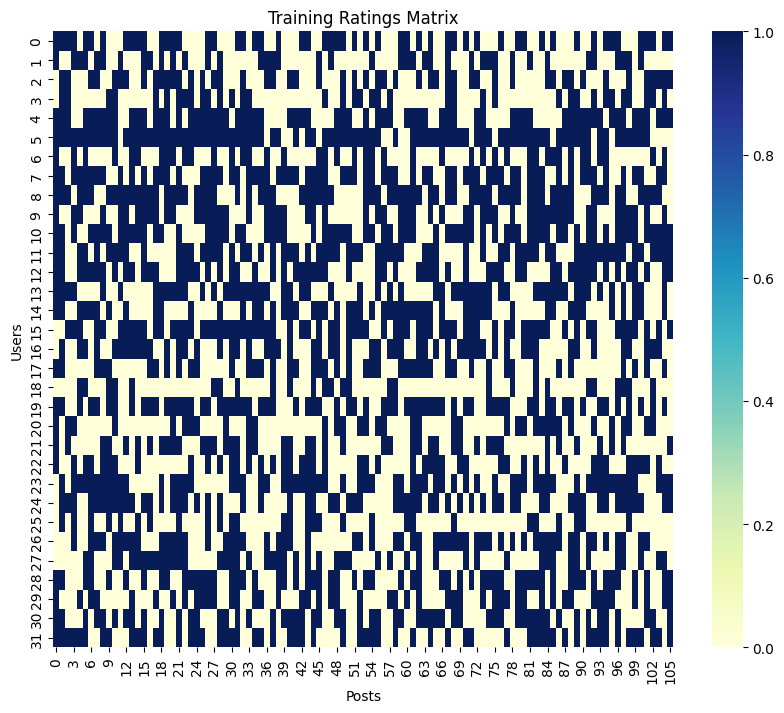

------------------------------------------------------
user similarity shape:  (32, 32)
user similarity:  [[1.         0.38729833 0.50037023 ... 0.5696138  0.50917508 0.53605627]
 [0.38729833 1.         0.35777088 ... 0.3423266  0.40144827 0.45675014]
 [0.50037023 0.35777088 1.         ... 0.38783588 0.49135381 0.50137741]
 ...
 [0.5696138  0.3423266  0.38783588 ... 1.         0.42433421 0.43590638]
 [0.50917508 0.40144827 0.49135381 ... 0.42433421 1.         0.61412961]
 [0.53605627 0.45675014 0.50137741 ... 0.43590638 0.61412961 1.        ]]
------------------------------------------------------


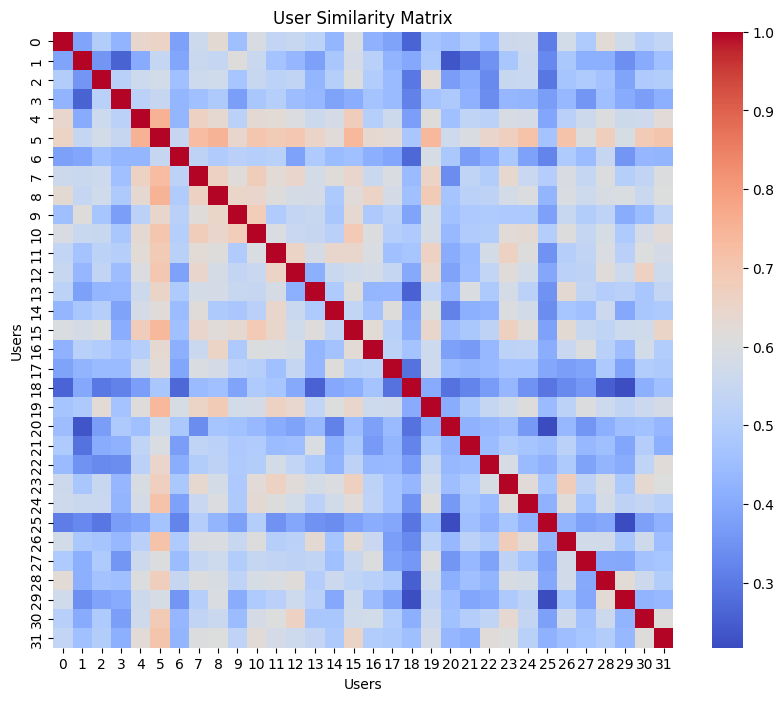

Processing recommendations for user index: 0
sim_scores:  [1.         0.38729833 0.50037023 0.4250655  0.6435959  0.65653216
 0.37796447 0.56108361 0.62985206 0.4546206  0.59408853 0.53602017
 0.54921047 0.52271347 0.42992532 0.59755195 0.42203611 0.38543439
 0.2618914  0.46901765 0.44743737 0.49236596 0.44141479 0.5613414
 0.56692694 0.3086067  0.57678728 0.49104638 0.62539898 0.5696138
 0.50917508 0.53605627]
------------------------------------------------------
similar users:  [ 5  4  8 28 15 10 26 29 24 23  7 12 31 11 13 30  2 21 27 19  9 20 22 14
  3 16  1 17  6 25 18]
------------------------------------------------------
post score:  [0.65653216 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216
 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216 0.
 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216
 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216
 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216 0.65653216
 0.65653216 0.65653216 

c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

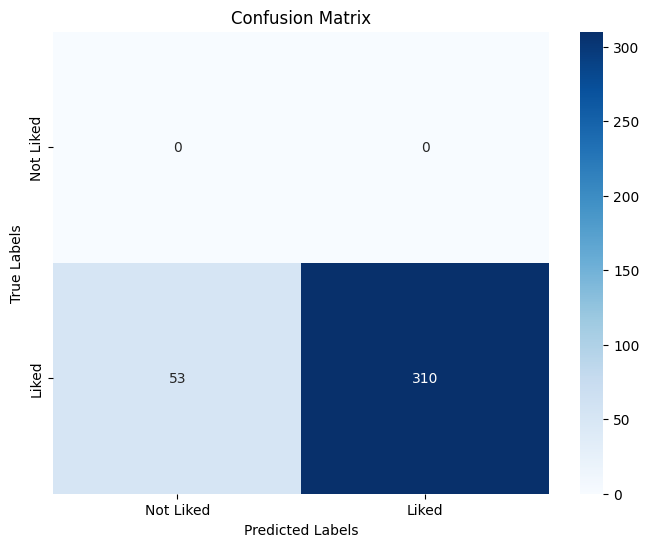

c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\estar\Project Python\Collaborative Filtering\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.85      0.92       363

    accuracy                           0.85       363
   macro avg       0.50      0.43      0.46       363
weighted avg       1.00      0.85      0.92       363

Mean Absolute Error: 0.14600550964187328
Precision: 1.0
Recall: 0.8539944903581267
F1 Score: 0.9212481426448736
Precision: 1.0
Recall: 0.8539944903581267
F1 Score: 0.9212481426448736


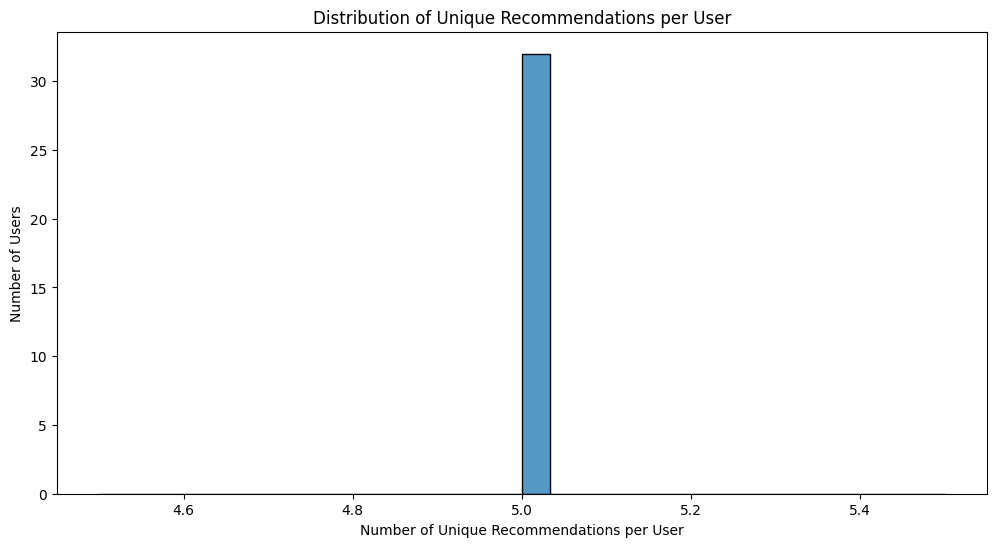

Recommendations for user 669c0b8e2ea43ac3b0c83bd8: ['66a7ed8ed84c8562211dc64d', '66a7ed8ed84c8562211dc67e', '66a7ed8dd84c8562211dc5f5', '66a7ed8ed84c8562211dc75e', '66a7ed8ed84c8562211dc66b']
Recommendations for user 66a7f79973caa3220fe40b6b: ['66a7ed8ed84c8562211dc75e', '66a7ed8ed84c8562211dc6b7', '66a7ed8ed84c8562211dc665', '66a7ed8ed84c8562211dc6f0', '66a7ed8ed84c8562211dc6fd']
Recommendations for user 66a0ae5660cb65cbc9feb87e: ['66a7ed8ed84c8562211dc64d', '66a7ed8ed84c8562211dc75e', '66a7ed8ed84c8562211dc66b', '66a7ed8ed84c8562211dc737', '66a7ed8ed84c8562211dc6fd']
Recommendations for user 66a0ae5660cb65cbc9feb878: ['66a7ed8ed84c8562211dc64d', '66a7ed8dd84c8562211dc5f5', '66a7ed8ed84c8562211dc75e', '66a7ed8ed84c8562211dc74b', '66a7ed8ed84c8562211dc6f0']
Recommendations for user 66a0ae5660cb65cbc9feb870: ['66a7ed8ed84c8562211dc64d', '66a7ed8ed84c8562211dc67e', '66a7ed8ed84c8562211dc735', '66a7ed8ed84c8562211dc6b7', '66a7ed8ed84c8562211dc67c']


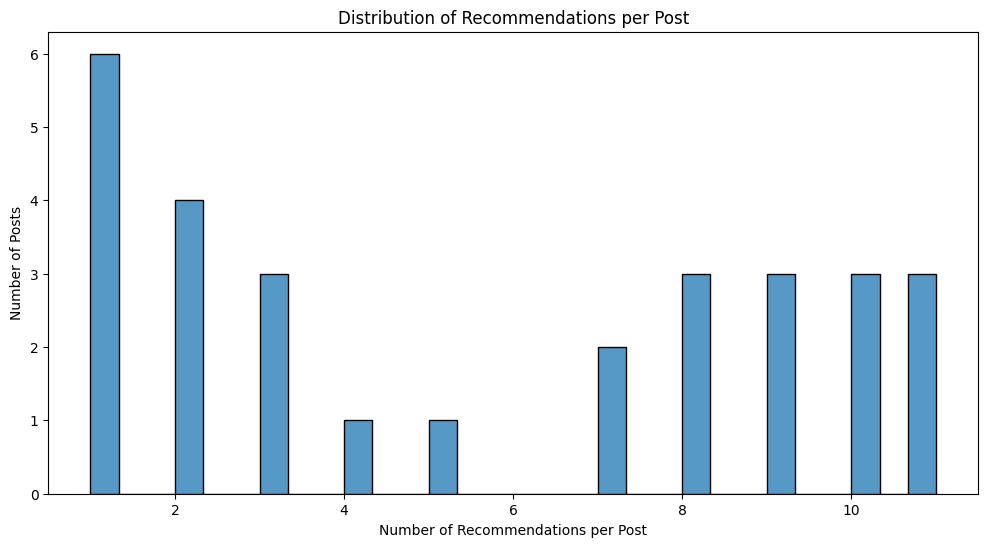

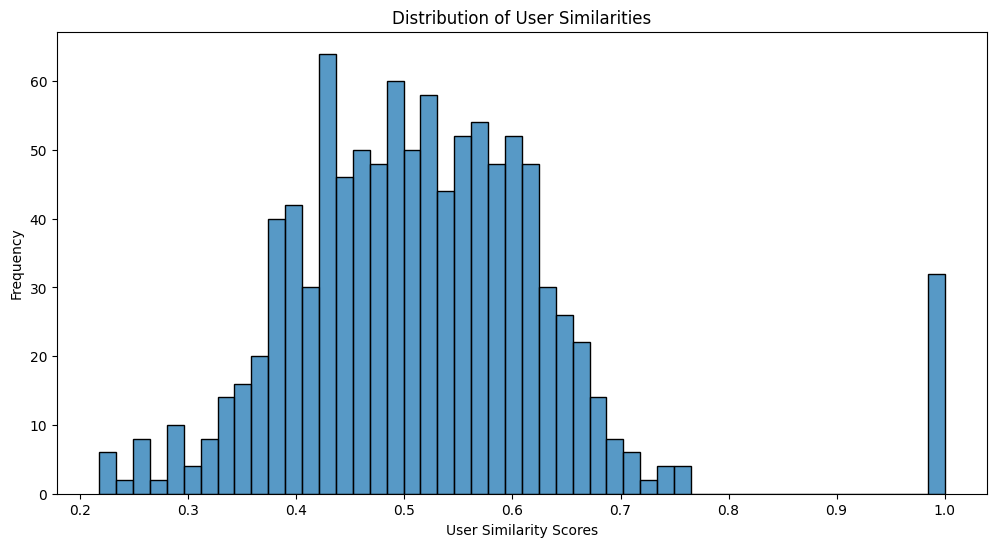

In [25]:
def visualize_user_similarity(user_similarity):
    # Distribution of user similarities
    similarity_scores = user_similarity.flatten()
    plt.figure(figsize=(12, 6))
    sns.histplot(similarity_scores, bins=50, kde=False)
    plt.xlabel('User Similarity Scores')
    plt.ylabel('Frequency')
    plt.title('Distribution of User Similarities')
    plt.show()

# Train the model
query='apa'
result = train_search_model(query)

if result is not None:
    train_matrix, recommendations, user_similarity = result
    # Visualize the recommendations and user similarities
    visualize_recommendations(recommendations)
    visualize_user_similarity(user_similarity)
else:
    print("Gagal melatih model. Tidak dapat melanjutkan.")